## Problem set 3: Nonparametric Estimation of First Price Procurement Auctions

In [34]:
from pathlib import Path
import logging
from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.stats import gaussian_kde
from statsmodels.distributions.empirical_distribution import ECDF

# for plots
plt.style.use('seaborn-v0_8-whitegrid')

# Ensure reproducibility
np.random.seed(2609)

### Step 1: Scrape bidding data

In [42]:
from scrape import run_cdot_scraper

pages = [
    "https://www.codot.gov/business/bidding/bid-tab-archives/copy_of_bid-tabs-2023",
    "https://www.codot.gov/business/bidding/bid-tab-archives/2023-bid-tabs/bid-tabs-2023",
    "https://www.codot.gov/business/bidding/bid-tab-archives/2022-bid-tabs/copy_of_bid-tabs-2022",
    "https://www.codot.gov/business/bidding/bid-tab-archives"
]

df = await run_cdot_scraper(pages=pages)

INFO:scrape:Output folder: ../data
INFO:scrape:PDF folder: ../data/pdf
INFO:scrape:https://www.codot.gov/business/bidding/bid-tab-archives: found 66 DocPop links


CancelledError: 

### Step 2: Extract number of bidders and lowest bid from PDFs

In [1]:
from extract_bidding_data import extract_metrics_from_pdf

logging.basicConfig(level=logging.INFO)

pdf_dir = '../data/pdf'
out_path = '../data/bid_min_and_count.csv'

pdfs = sorted(Path(pdf_dir).rglob("*.pdf"))
results = []

for pdf in tqdm(pdfs, desc="Processing PDFs"):
    n, low = extract_metrics_from_pdf(pdf)
    results.append((str(pdf), n, low))
    # Print progress for each file

# Create DataFrame
df = pd.DataFrame(results, columns=["file", "num_bidders", "lowest_bid"])

# Write to CSV
Path(out_path).parent.mkdir(parents=True, exist_ok=True)
df.to_csv(out_path, index=False)
df

Processing PDFs: 100%|██████████| 401/401 [10:46<00:00,  1.61s/it]


,file,num_bidders,lowest_bid
0,../data/pdf/Project_18808_Bid_Tab.pdf,7,5282791.00
1,../data/pdf/Project_19164_Bid_Tab.pdf,7,2595839.00
2,../data/pdf/Project_19771_Bid_Tab.pdf,5,3776448.13
3,../data/pdf/Project_19934_Bid_Tab.pdf,7,3298573.72
4,../data/pdf/Project_20169_Bid_Tab.pdf,5,6735433.99
...,...,...,...
396,../data/pdf/Project_26943_Bid_Tab.pdf,4,195959.50
397,../data/pdf/Project_26969_Bid_Tab.pdf,2,1373255.58
398,../data/pdf/Project_27031_Bid_Tab.pdf,2,2769129.65
399,../data/pdf/Project_27057_Bid_Tab.pdf,3,488198.00


### Step 3: Estimate cost distribution

In [8]:
def pseudo_cdf(pseudo_values):
    # Get the number of pseudo_values
    length_ps = pseudo_values.shape[0]
    
    # Initialize an array for the pseudo CDF
    pseudo_cdf_distr = np.zeros_like(pseudo_values)

    # Loop through each element in pseudo_values
    for r in range(length_ps):
        # Calculate the empirical CDF at the current element        
        pseudo_cdf_distr[r] = (1/(length_ps)) * (1+np.where(pseudo_values == pseudo_values[r])[0][0])
    return pseudo_cdf_distr


def pseudo_pdf(pseudo_bids):
    # Sort pseudo_bids
    sorted_bids = np.sort(pseudo_bids)
    
    # Initialize arrays
    pseudo_pdf = np.zeros_like(pseudo_bids)
    triweightker = np.zeros_like(pseudo_bids)
    obj_triw = np.zeros_like(pseudo_bids)

    # Calculate delta
    delta = 2.978 * 1.06 * (np.var(pseudo_bids)**(1/2))**(-1/6)

    for r in range(len(pseudo_bids)):
        triweightker[:] = 0
        
        # Calculate obj_triw
        obj_triw[:] = (1/delta) * (sorted_bids - sorted_bids[r])
        
        # Calculate triweightker
        triweightker = np.where(np.abs(obj_triw) <= 1, (35/32)*(1-obj_triw**2)**3, 0)
        
        # Calculate striweightker
        striweightker = (1/delta) * np.sum(triweightker)
        
        # Calculate pseudo_pdf
        pseudo_pdf[r] = (1/len(pseudo_bids)) * striweightker

    return pseudo_pdf

In [3]:
# Import second file
df = pd.read_csv(r'../data/bid_min_and_count.csv')
df.columns = ['t', 'N', 'W']
df.dropna(inplace=True)
df = df[df['N']>1]
df = df[df['W']>0]

# Sorting values with respect to number of bidders
data = df[['N','W']]
data = data.sort_values(by='N')
data.head()

,N,W
400,2,2542335.29
206,2,3888046.00
208,2,1168613.00
103,2,693896.87
102,2,744942.00


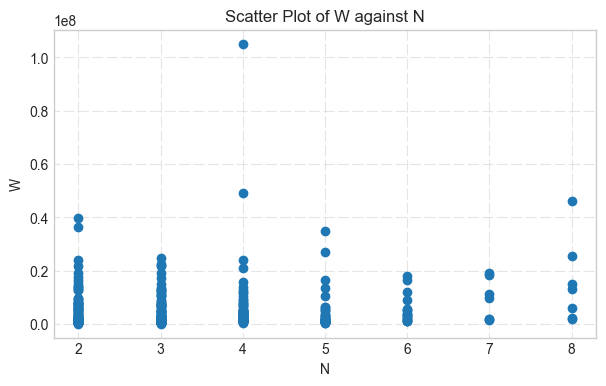

In [4]:
# Plotting (What is the relationship between the winning bid and the number of bidders?)
plt.figure(figsize=(7,4))
plt.grid(alpha = 0.5, ls = (5, (10, 3)))

plt.scatter(data['N'], data['W'])
plt.xlabel('N')
plt.ylabel('W')
plt.title('Scatter Plot of W against N')
plt.show()

In [5]:
# Observed counts of number of bidders
data['N'].value_counts()

N
3    92
2    85
4    63
5    34
6    18
7     7
8     7
Name: count, dtype: int64

/var/folders/tp/qp7bqb4s1q124w0qwz813fjm0000gn/T/ipykernel_66724/468625407.py:53: RuntimeWarning: divide by zero encountered in power
  fc = (((1-Fz)**((1/i_avg)-1))*fz)/i_avg


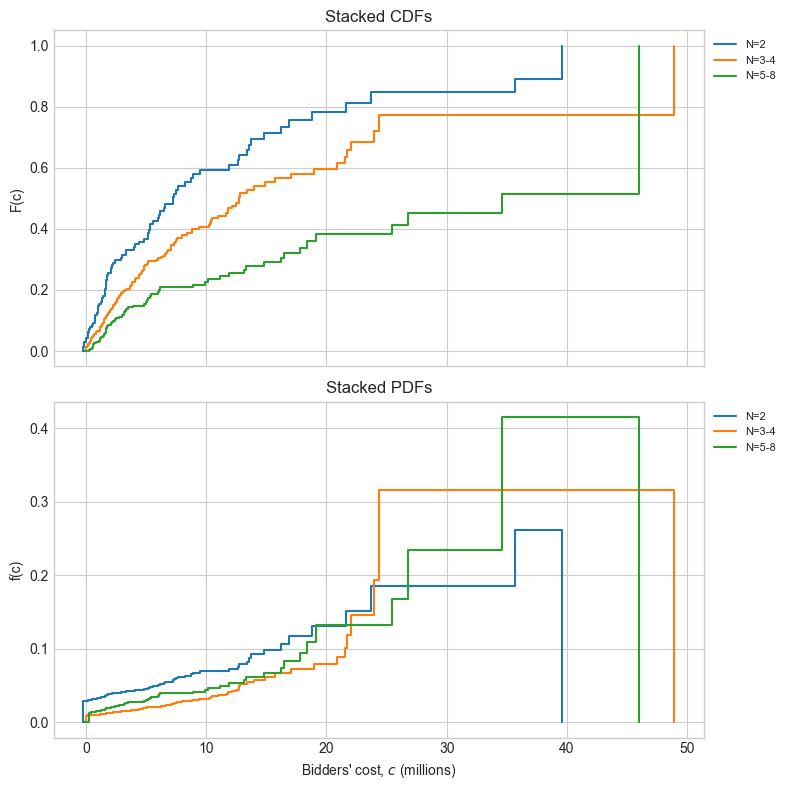

In [33]:
# Three groups of number of bidders
groups = {
    'N=2': [2],
    'N=3-4': [3, 4],
    'N=5-8': [5, 6, 7, 8]
}

# Data preparation for cost distribution calculations
N = data.to_numpy()[:, 0]
W = data.to_numpy()[:, 1]
Ns = np.unique(N)

# Get value counts for weighted average
n_counts = data['N'].value_counts()

# Create subplots
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 8), sharex=True)

for group_name, n_values in groups.items():
    # Collect all data for this group
    w_group = []
    for i in n_values:
        w_group.extend(W[N == i])
    w_group = np.array(w_group)
    
    # Calculate weighted average N for the group
    total_count = sum(n_counts[i] for i in n_values if i in n_counts)
    i_avg = sum(i * n_counts[i] for i in n_values if i in n_counts) / total_count
    
    # Estimate empirical CDF and PDF of winning bids
    ecdf_w = ECDF(w_group)
    F1 = ecdf_w.y
    Fw = F1[1:]
    kde = gaussian_kde(w_group)
    fw = kde.evaluate(w_group)
    
    # Estimate the cost corresponding to the winning bid
    epsilon = 1e-6
    c_win = w_group - (((1/(i_avg-1)) * (1-Fw))/(fw + epsilon))
    
    # drop costs above 100 millions
    c_win = c_win[c_win <= 100e6]
    c_win_millions = c_win / 1e6
    
    # Estimate the pseudo CDF and pseudo PDF
    ecdf_cw = ECDF(c_win)
    F1 = ecdf_cw.y
    Fz = F1[1:]
    fz = pseudo_pdf(c_win)
    
    # Estimate the CDF and PDF of cost
    Fc = 1-(1-Fz)**(1/i_avg)
    fc = (((1-Fz)**((1/i_avg)-1))*fz)/i_avg
    fc[-1] = 0    
   
    # Plotting the stacked CDFs and PDFs
    axes[0].plot(np.insert(np.sort(c_win_millions), 0, 0), np.insert(Fc, 0, 0), label=group_name, drawstyle='steps-post')
    axes[1].plot(np.insert(np.sort(c_win_millions), 0, 0), np.insert(fc, 0, 0), label=group_name, drawstyle='steps-post')

# Set labels and legends for the first subplot
axes[0].set_ylabel("F(c)")
axes[0].set_title("Stacked CDFs")
axes[0].legend(loc='upper left', bbox_to_anchor=(1, 1), prop={'size': 8})

# Set labels and legends for the second subplot
axes[1].set_xlabel("Bidders' cost, $c$ (millions)")
axes[1].set_ylabel("f(c)")
axes[1].set_title("Stacked PDFs")
axes[1].legend(loc='upper left', bbox_to_anchor=(1, 1), prop={'size': 8})

plt.tight_layout()
plt.savefig('../data/FC_steps_plot.pdf', bbox_inches="tight")
plt.show()